# Python, Centrale Lille, G3 SDIA
---
## TP4 : K-nearest neighbours (K-NN) classification with numpy, scikit-learn and cython.

---
## Guidelines (read carefully before starting)


**Objectives**: acquire further practice with standard techniques and libraries to significantly accelerate (serial) `numpy` codes (cython, `numba`). The implementation will be compared and validated against the corresponding scikit-learn implementation.

**Guidelines**: after retrieving the resources for the lab on moodle:
- place the `.zip` archive in a local folder (Computer -> Documents/Python/);
- unzip the archive `.zip`;
- rename the folder with the convention `tp4_Name1_Name2`;
- duplicate the notebook file and rename it `tp4_Name1_Name2.ipynb`;
- [**optional, possibly needed if working from Centrale's machines**]
    - create a `tp4` conda environment from the provided `requirement.txt` file
    ```bash
    conda create --name=tp4 --file=requirement.txt
    conda activate tp4
    # do not forget to deactivate the environment if needed
    # you can remove the environment once you are done
    conda env remove --name=tp4
    ```
    - launch jupyter notebook (the python environment will be the one from the conda environment `tp4`)
- at the end of the session, do not forget to transfer your work to your own network space if you are working on a machine from the school (do not leave your work on the C: drive).

**Assessment** &#8594; global grade from F to A (A+)

This lab session will be evaluated, based on your answer to the exercises reported in a Jupyter notebook (e.g., this one) and any additional `.py` file produced. Any code produced should be commented whenever appropriate, custom functions and objects documented and unit-tested (see session 1). Figure produced should be clearly annotated (axis, title, legend whenever appropriate).

1. Numerical correctness
2. Implementation clarity (documentation, relevance of the comments)
3. Unit-tests developed whenever appropriate (correctness, relevance)
4. Answers to the questions and overall presentation of the Jupyter notebook.

**Useful references for this lab**:

[1] scikit-learn: [documentation](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification)

[2] `numba`: [documentation](http://numba.pydata.org/) 

[3] cython: [a very useful tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), and [another one](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html)



## <a name="content">Contents</a>
- [Exercise 1: KNN classification with numpy and sklearn](#ex1)
- [Exercise 2: Code acceleration with cython](#ex2)
- [[Bonus] Exercise 3: Code acceleration with numba](#ex3)
---

In [1]:
%load_ext autoreload
%autoreload 2

## <a name="ex1">Exercise 1: K-Nearest Neighbours (K-NN) classification with numpy and scikit-learn</a> [(&#8593;)](#content)

This session is a first introduction to classification using the most intuitive non parametric method: the $K$-nearest neighbours. The principle is [the following](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification). A set of labelled observations is given as a learning set. A classification taks then consists in assigning a label to any new observation. In particular, the K-NN approach consists in assigning to the observation the most frequent label among its $K$ nearest neighbours taken in the training set.

### A. Validation on synthetic data

Load the training and test datasets `data/synth_train.txt` and `data/synth_test.txt`. Targets belong to the set $\{1,2\}$ and entries belong to $\mathbb{R}^2$. The file `data/synth_train.txt` contain 100 training data samples, and `data/synth_test.txt` contains 200 test samples, where:

- the 1st column contains the label of the class the sample;
- columns 2 & 3 contain the coordinates of each sample (in $\mathbb{R}^2$).

Useful commands can be found below.

```python
# load the training set
train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]
```

```python
# load the test set
test = np.loadtxt('/datasynth_test.txt') 
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]
```

1\. Display the training set and distinguish the two classes. 

> Hint: useful functions include `matplotlib.pyplot.scatter` or `matplotlib.pyplot.plot`.

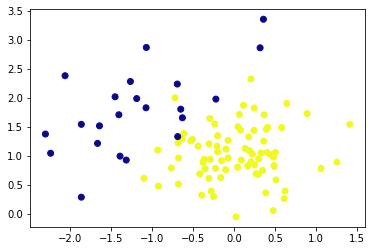

In [2]:
#Q1
import matplotlib.pyplot as plt
import numpy as np

# load the training set
train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0] #list of labels
x_train = train[:,1:] #coordinates
N_train = train.shape[0] #number of lines

plt.scatter(x_train[:,0],x_train[:,1], c=class_train, cmap='plasma')
plt.show()
# print(train)
# print(class_train)
# print(x_train)
# print(N_train)

2\. Implement the K-nearest neighbours algorithm for classification.

> Hint: 
> - useful functions include `numpy.linalg.norm`, `numpy.argsort`, `numpy.bincount`;
> - for an optimized partial sorting procedure, you may have a look at the [`bottleneck.argpartition` function](https://bottleneck.readthedocs.io/en/latest/reference.html#bottleneck.argpartition).

In [3]:
#Q2
import numpy as np
from numpy import linalg as LA
import timeit

# load the test set
test = np.loadtxt('data/synth_test.txt') 
class_test = test[:,0] #list of labels
x_test = test[:,1:] #coordinates
N_test = test.shape[0] #number of lines
# print(test)
# print(class_test_1)
# print(class_test_2)
# print(x_test) 
# print(N_test)

def knn2 (trainingSet, testInstance, k):
    distances = []
    # Calculating distance between each row of training data and test data
    for i in range(len(trainingSet)):
        distances.append(LA.norm(testInstance-trainingSet[i,1:]))
    # Sorting them on the basis of distance, and selecting the k first index
    index_knn = np.argsort(distances)[0:k]
    #Getting list of class of the k nearest neighbours
    knn = trainingSet[index_knn][:,0]
    #Converting them into Integers for bincount function
    knn = [int(i) for i in knn]
    a = np.bincount(knn)
    return np.argmax(a) #return the most recurent label in the k nearest neighbours set

#Full numpy knn
def knn3(trainingSet, testSet, k):
    b = trainingSet[:,1:].repeat(len(testSet),axis=0).reshape(len(testSet),len(testSet),2) - testSet
    distances=np.linalg.norm(b,axis=2)
    index_knn = np.argsort(distances)[:,1:k+1]
    knn_labels = trainingSet[index_knn,0].astype(int)
    number_of_iter_of_each_label = np.apply_along_axis(np.bincount,1,knn_labels)
    label_most_present = np.apply_along_axis(np.argmax,1,number_of_iter_of_each_label)
    return(label_most_present)
  

3\. Compute the error rate on the training set and the test set for $K \in \{1,2, \dotsc, 20\}$. Display the classification result (see 1.) for the configuration with the lowest error rate.

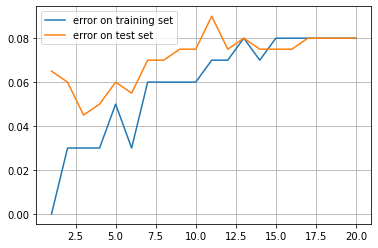

In [4]:
#Q3
def error_rate(train_set,x,class_list,k):
    prediction = np.zeros(len(x))
    for i in range(len(prediction)):
        prediction[i] = knn2(train_set,x[i],k)
    a = np.absolute(prediction-class_list)
    return np.mean(a)

empirical_error,generalisation_error = np.zeros(20), np.zeros(20)
for k in range(1,21):
    empirical_error[k-1] = error_rate(train,x_train,class_train,k)
    generalisation_error[k-1] = error_rate(train,x_test,class_test,k)
    
plt.plot(np.arange(1,21),empirical_error, label='error on training set')
plt.plot(np.arange(1,21),generalisation_error, label='error on test set')
plt.grid()
plt.legend()

4\. Comment on your results. Which value of $K$ seems optimal ?


#Q4
k=3 seems optimal to lower the generalisation error

5\. Compare the results of you implementation with those of [`sklearn.neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier). Compare the runtime of these two versions using the [`timeit`](https://docs.python.org/3/library/timeit.html) module (see session 1).

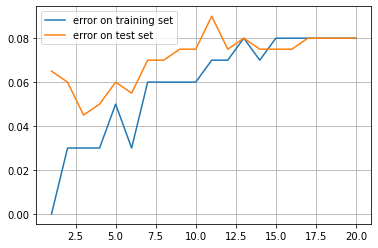

In [5]:
#Q5
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

empirical_error,generalisation_error = np.zeros(20), np.zeros(20)
for k in range (1,21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, class_train)
    y_pred = knn.predict(x_train)
    empirical_error[k-1] = 1-metrics.accuracy_score(class_train,y_pred)
    y_pred = knn.predict(x_test)
    generalisation_error[k-1] = 1-metrics.accuracy_score(class_test,y_pred)

plt.plot(np.arange(1,21),empirical_error, label='error on training set')
plt.plot(np.arange(1,21),generalisation_error, label='error on test set')
plt.grid()
plt.legend()

My knn2 function give the same result as the KNeighborsClassifier from sklearn,
Now let's compare their runtime

In [6]:
%%timeit -r 10
#My version of knn
prediction = np.zeros(len(x_train))
for i in range(len(prediction)):
    prediction[i] = knn2(train,x_train[i],3)

71.9 ms ± 2.81 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [7]:
%%timeit -r 10
#knn classifier from sklearn
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, class_train)
y_pred = knn.predict(x_train)

3.98 ms ± 222 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


### B. Application to a real dataset (Breast cancer Wisconsin).

6\. Apply the K-NN classifier to the real dataset `data/wdbc12.data.txt.` Further details about the data are provided in `data/wdbc12.names.txt`.

In [40]:
#Q6
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss
# load the training set
train = np.loadtxt('data/wdbc12.data.txt', delimiter=',')
X = train[:,2:] #list of attributes
y = train[:,1] #labels

# Split the data into 70% training data and 30% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

k=3
# Train
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
# Predict
ypred_train = knn.predict(X_train)
#Empirical loss
loss = zero_one_loss(y_train, ypred_train)
print("Empirical error :",loss)
#Generalization error
ypred_test = knn.predict(X_test)
loss = zero_one_loss(y_test, ypred_test)
print("Generalization error :",loss)

Empirical error : 0.04020100502512558
Generalization error : 0.07602339181286555


## <a name="ex2">Exercise 2: Code acceleration with cython</a> [(&#8593;)](#content)

Cython allows C code to be easily interfaced with Python. It can be useful to make your code faster for a small coding effort, in particular when using loops. A general approach to optimize your code is outlined in the [Scipy lecture notes, Section 2.4](https://scipy-lectures.org/advanced/optimizing/index.html). Complementary reading about interfacing Python with C can be found in [Section 2.8](https://scipy-lectures.org/advanced/interfacing_with_c/interfacing_with_c.html).

1\. Read carefully the [cython tutorial](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html), which describes step by the step how the toy example reported below has been developed.

**Setup**: Compile the toy example provided in `example_cy/` by running, in the command line (anaconda prompt on windows)

```bash
python example_cy/setup.py build_ext --inplace
```

Note that the compilation process has been slightly automatised with the instructions reported in `example_cy/setup.py`. To test the module, run

In [9]:
import pyximport
pyximport.install()

(None, <pyximport.pyximport.PyxImporter at 0x2317020dbb0>)

In [10]:
import example_cy.helloworld as toy
toy.printhello()

Hello World


which should display
```python
Hello World
```

> Warning: 
> - do not forget to include an empty `__init__.py` file in the directory where your source code lives (`import` will fail if this is not the case).
> - in case you have any setup issue, take a look at the `notes.md` file.

2\. Read the Numpy/Cython [tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), focussing on the paragraphs **Cython at a glance**, and **Your Cython environment** until **"More generic code"**. Apply step-by-step the techniques specified in this document to accelerate the numpy version of the K-NN classifier implemented in [Exercise 1](#ex1) (*i.e.*, compile and time your code after each step to report the evolution).

> Remarks: 
> - the `annotate=True` flag in the `setup.py` allows an additional `.html` document to be generated (`<your_module_name>.html`), showing, for each line of the Cython code, the associated C instructions generated. Highlighted in yellow are the interactions with Python: the darker a region appears, the less efficient the generated C code is for this section. Work in priority on these! 
> - make sure all the previously generated files are deleted to allow the .html report to be generated;
> - if you are working on your own machine and don't have a C/C++ compiler installed, read the notes provided in `notes.md`;
> - use `cdef` for pure C functions (not exported to Python), `cpdef` should be favored for functions containing C instructions and later called from Python.

In [15]:
#Q2

# load the training set
train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0] #list of labels
x_train = train[:,1:] #coordinates
N_train = train.shape[0] #number of lines

import pyximport
pyximport.install()
from knn_cy.knn_cy import go
go(train,x_train)


3\. Use Cython to implement a faster version of the numpy K-NN classifier implemented in [Exercise 1](#ex1). An example to compile a `.pyx` file depending on `numpy` is included in `example_np_cy/`.

> Hint: if you keep numpy arrays, make sure you use memory views (see numpy/cython tutorial) to access the elements within it. Beware input type (you may need to recast the format of the input elements before entering the function. The `numpy.asarray` function can prove useful).

In [12]:
# answer

4\. Compare the runtime of the two algorithms (using `timeit.timeit`), and conclude about the interest of using cython in this case.

In [13]:
# answer

5\. **[TO BE REMOVED IF NEEDED]** [**Bonus**] `numba` is a just-in-time (JIT) compiler which translates Python codes into efficient machine code at runtime. A significant acceleration can be obtained by adding a few simple decorators to a standard Python function, up to a few restrictions detailed [here](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html).

Take a look at the [numba 5 min tour](http://numba.pydata.org/numba-doc/latest/user/5minguide.html), and try to accelerate your `numpy` implementation of the KNN algorithm with the `@jit` decorator. You may have to rewrite small portions of your code to get the expected acceleration (see [performance tips](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html)).

> Note: 
> - If you have written most of the KNN classifier of exercise 1 with numpy, there is little chance that you will get an acceleration with numba (justifying the use of cython in this case).
> - > **Warning**: first run the numba version once to trigger the compilation, and then time it as usual. This is needed to avoid including the JIT compilation step in the runtime.

In [14]:
# answer